# Importowanie niezbędnych bibliotek

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.autograd import Variable
from torchvision import datasets, transforms

# PRACA Z CPU

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# PRZYGOTOWANIE ZESTAWU DANYCH

In [3]:
train_set = torchvision.datasets.MNIST(
    root='./data/MNIST',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ])
)

In [4]:
test_set = torchvision.datasets.MNIST(
    root='./data/MNIST',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ])
)

# DEFINIOWANIE MODUŁÓW ŁADUJĄCYCH DANE

In [5]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, drop_last=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, drop_last=True)

# ITERACJA W PARTII

In [6]:
sample = next(iter(train_set))
image = sample[0]
label = sample[1]
image.shape

torch.Size([1, 28, 28])

In [7]:
batch = next(iter(trainloader))
images, labels = batch
images.shape

torch.Size([64, 1, 28, 28])

# Wizualizacja danych

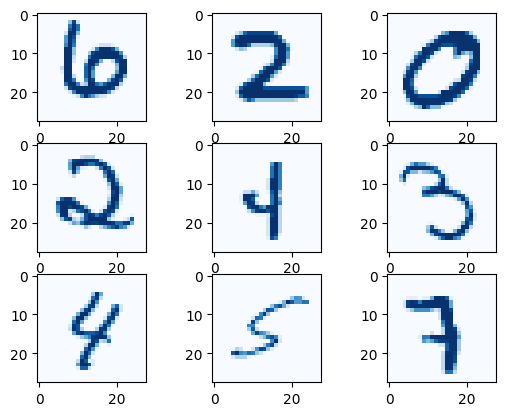

In [8]:
n = 9
for index in range(1, n + 1):
    plt.subplot(3, 3, index)
    plt.imshow(images[index].numpy().squeeze(), cmap='Blues')

# TWORZENIE KONWOLUCYJNEJ STRUKTURY SIECI NEURONOWEJ

In [9]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.fc1 = nn.Linear(in_features=12 * 4 * 4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
    
    def forward(self, t):
        t = F.relu(self.conv1(t))
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        t = F.relu(self.conv2(t))
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        t = F.relu(self.fc1(t.reshape(-1, 12 * 4 * 4)))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

# TWORZENIE OBIEKTU

In [10]:
network = Network()
network.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

# TRENOWANIE SIECI

In [11]:
network.cpu()

num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        train = Variable(images.view(64, 1, 28, 28))
        labels = Variable(labels)
        outputs = network(train)
        loss = error(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1
        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(64, 1, 28, 28))
                outputs = network(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print(f'Iteration: {count}, Loss: {loss.data}, Accuracy: {accuracy}')

Iteration: 500, Loss: 0.11247903108596802, Accuracy: 97.05529022216797
Iteration: 1000, Loss: 0.2655560076236725, Accuracy: 97.37580108642578
Iteration: 1500, Loss: 0.018003912642598152, Accuracy: 98.18709564208984
Iteration: 2000, Loss: 0.12706398963928223, Accuracy: 98.37740325927734
Iteration: 2500, Loss: 0.004489350598305464, Accuracy: 98.40745544433594
Iteration: 3000, Loss: 0.04137292876839638, Accuracy: 98.25720977783203
Iteration: 3500, Loss: 0.025247491896152496, Accuracy: 98.74799346923828
Iteration: 4000, Loss: 0.1359165906906128, Accuracy: 98.828125
Iteration: 4500, Loss: 0.04444274306297302, Accuracy: 98.74799346923828
